In [81]:
# Import statements
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import normalize

In [82]:
# Use GPU if it exists
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [83]:
# Directory paths

img_dir = "original/"
mask_dir = "annotated/"

img_paths = [file for file in Path(img_dir).iterdir() if not file.name.startswith(".")]
mask_paths = [file for file in Path(mask_dir).iterdir() if not file.name.startswith(".")]

In [84]:
df = pd.DataFrame({"image_path": img_paths,
                   "mask_paths": mask_paths}, dtype=str)

df.head()
result=df.dtypes
print(result)

image_path    object
mask_paths    object
dtype: object


In [85]:
# Dataset

class CuffDataset(Dataset):
    def __init__(self, df, transforms):
        # df contains the paths to all files
        self.df = df
        # transforms is the set of data augmentation operations
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):                   
        image = cv2.imread(self.df.iloc[idx, 0])/255
        mask = cv2.imread(self.df.iloc[idx, 1], 0)/255

        #image = self.transforms(image)
        #mask = self.transforms(mask)
        #image = self.strong_transforms(image=image)['image']

        augmented = self.transforms(image=image,
                                    mask=mask)

        image = augmented['image'] # Dimension (3, 255, 255)
        mask = augmented['mask']   # Dimension (255, 255)

        image = normalize(image, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
                          inplace=True)

        # We notice that the image has one more dimension (3 color channels), so we have to one one "artificial" dimension to the mask to match it
        mask = np.expand_dims(mask, axis=0) # Dimension (1, 255, 255)

        return image, mask

In [86]:
# Dataset
'''
class CuffDataset(Dataset):
    def __init__(self, df, basic_transforms, strong_transforms):
        # df contains the paths to all files
        self.df = df
        # transforms is the set of data augmentation operations
        self.basic_transforms = basic_transforms
        self.strong_transforms = strong_transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):                   
        image = cv2.imread(self.df.iloc[idx, 0])
        mask = cv2.imread(self.df.iloc[idx, 1], 0)

        #image = self.transforms(image)
        #mask = self.transforms(mask)
        image = self.strong_transforms(image=image)['image']

        augmented = self.basic_transforms(image=image,
                                    mask=mask)

        image = augmented['image'] # Dimension (3, 255, 255)
        mask = augmented['mask']   # Dimension (255, 255)
    

        # We notice that the image has one more dimension (3 color channels), so we have to one one "artificial" dimension to the mask to match it
        mask = np.expand_dims(mask, axis=0) # Dimension (1, 255, 255)

        return image, mask
'''

'\nclass CuffDataset(Dataset):\n    def __init__(self, df, basic_transforms, strong_transforms):\n        # df contains the paths to all files\n        self.df = df\n        # transforms is the set of data augmentation operations\n        self.basic_transforms = basic_transforms\n        self.strong_transforms = strong_transforms\n\n    def __len__(self):\n        return len(self.df)\n    \n    def __getitem__(self, idx):                   \n        image = cv2.imread(self.df.iloc[idx, 0])\n        mask = cv2.imread(self.df.iloc[idx, 1], 0)\n\n        #image = self.transforms(image)\n        #mask = self.transforms(mask)\n        image = self.strong_transforms(image=image)[\'image\']\n\n        augmented = self.basic_transforms(image=image,\n                                    mask=mask)\n\n        image = augmented[\'image\'] # Dimension (3, 255, 255)\n        mask = augmented[\'mask\']   # Dimension (255, 255)\n    \n\n        # We notice that the image has one more dimension (3 colo

In [87]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

PATCH_SIZE = 256

'''
strong_transforms = A.Compose([
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.Emboss(p=0.25),  # replaced A.IAAEmboss with A.Emboss
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    ], p=0.8),

    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), p=1.0),
])
'''

transforms = A.Compose([
    A.RandomCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    ToTensorV2(),
])


In [88]:
'''
# Transformations
import torchvision.transforms as transforms

PATCH_SIZE = 256

transform_train = transforms.Compose([
    # Scale the image up to a square of 40 pixels in both height and width
    # transforms.Resize(), #  NEed to check pixel size and height LOL
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then scale it to a square of 32 pixels in both height and
    # width
   #  transforms.RandomResizedCrop(, scale=(0.64, 1.0),
    #                                                ratio=(1.0, 1.0)),
    transforms.RandomCrop(size=(PATCH_SIZE, PATCH_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    # Standardize each channel of the image
    transforms.Normalize([0.5, 0.5, 0.5], # Is this the best normalization? Or [0.5, 0.5, 0.5]?
     [0.5, 0.5, 0.5])])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], # Is this the best normalization? Or [0.5, 0.5, 0.5]?
     [0.5, 0.5, 0.5])
    ])
'''

'\n# Transformations\nimport torchvision.transforms as transforms\n\nPATCH_SIZE = 256\n\ntransform_train = transforms.Compose([\n    # Scale the image up to a square of 40 pixels in both height and width\n    # transforms.Resize(), #  NEed to check pixel size and height LOL\n    # Randomly crop a square image of 40 pixels in both height and width to\n    # produce a small square of 0.64 to 1 times the area of the original\n    # image, and then scale it to a square of 32 pixels in both height and\n    # width\n   #  transforms.RandomResizedCrop(, scale=(0.64, 1.0),\n    #                                                ratio=(1.0, 1.0)),\n    transforms.RandomCrop(size=(PATCH_SIZE, PATCH_SIZE)),\n    transforms.RandomHorizontalFlip(),\n    transforms.RandomRotation(10),\n    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),\n    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),\n    transforms.ToTensor(),\n    # Standardize each channel of the image\

In [89]:
# Split df into train and test data
train_df, val_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape}")

Train: (28, 2) 
Val: (8, 2)


In [95]:
train_dataset = CuffDataset(train_df, transforms)
images, masks = train_dataset[0]
print(images.shape)
# print(train_dataset)
#mean, std = images.mean([0,2,3]), images.std([0,2,3])
#print(mean, std)

#image, mask = train_dataset[0]  # get the first item
#print(image.shape, mask.shape)
#print(image, mask)

torch.Size([3, 256, 256])


In [91]:
train_dataset = CuffDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=28, shuffle=False)

val_dataset = CuffDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [92]:
'''
def mean_std(loader):
  images, labels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
'''

images, labels = next(iter(train_dataloader))



Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1034, 2066, 3)
(1034, 2066, 3)


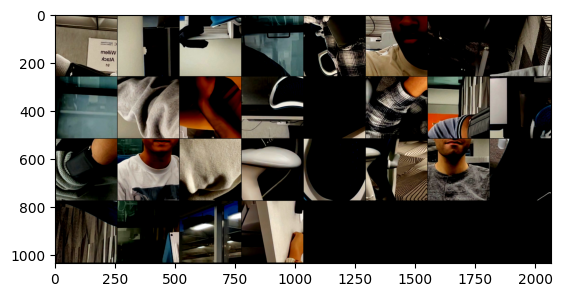

In [98]:
import matplotlib.pyplot as plt
import torchvision.utils

def imshow(img):
    #img = (img * 0.5 * 255) + (0.5 * 255)   # unnormalize
    npimg = np.float32(img)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    npimg = cv2.cvtColor(npimg, cv2.COLOR_BGR2RGB)
    print(npimg.shape)
    plt.imshow(npimg, vmin=0, vmax=1)


# get some random training images
dataiter = iter(train_dataloader)
images, masks = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

(1034, 2066, 3)
(1034, 2066, 3)
tensor(0., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]], dtype=torch.float64)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

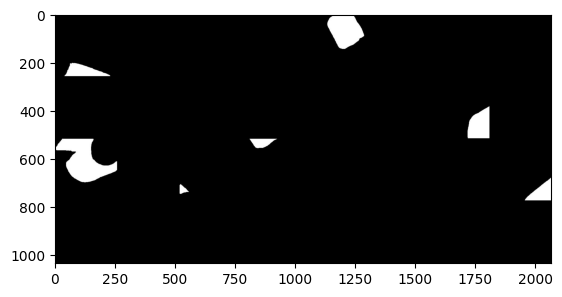

In [107]:
imshow(torchvision.utils.make_grid(masks))
print(torch.min(masks))
print(torch.max(masks))
print(masks[23])
#print((np.logical_or(np.asarray(masks) == 0, np.asarray(masks) == 255)).all())